In [2]:
%matplotlib notebook
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.patches 
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
import sys
import os
import os.path
import cv2

In [3]:
f = h5py.File("../CXI/cxi25410/res/iceFinderCampaign/output_r0144/type1/LCLS_2011_Feb28_r0144_163006_2feb_cspad.h5", 'r')
d = f['data/data'][:]
wavelength = f['LCLS/photon_wavelength_A'][0]/1e10
detector_distance = f['LCLS/detectorPosition'][0]/1000
pixel_size = 109.92*1e-6

In [4]:
# calculate qx, qy
image = d
center = None
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
xx, yy = np.meshgrid(x, y)
if center is None:
    xx = xx.astype(np.float64) - (image.shape[1]-1)/2
    yy = yy.astype(np.float64) - (image.shape[0]-1)/2
else:
    xx -= center[1]
    yy -= center[0]
rad = np.sqrt(xx*xx + yy*yy)
qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)

In [6]:
threshold = 2*(np.mean(image)+np.std(image))

In [7]:
# method 2 thresholding the whole image and set everything below threshold equal to zero
## find peak regions based on the value of the threshold
image_thresholded = np.copy(image)
image_thresholded[image<threshold] = 0
#find the peak regions and label all the pixels
labeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded)
peak_regions = scipy.ndimage.find_objects(labeled_image)

In [8]:
# make a list of the bounding box of the peaks
peak_list = []
centroid_list = []
qx_list = []
qy_list = []
for peak_region_i in peak_regions:
    if d[peak_region_i].shape[0]>15 and d[peak_region_i].shape[1]>15:
        cx = np.sum(d[peak_region_i]*qx[peak_region_i])/np.sum(d[peak_region_i])
        cy = np.sum(d[peak_region_i]*qy[peak_region_i])/np.sum(d[peak_region_i])
        qx_list.append(qx[peak_region_i])
        qy_list.append(qy[peak_region_i])
        peak_list.append(d[peak_region_i])
        centroid_list.append((cx,cy))

<IPython.core.display.Javascript object>


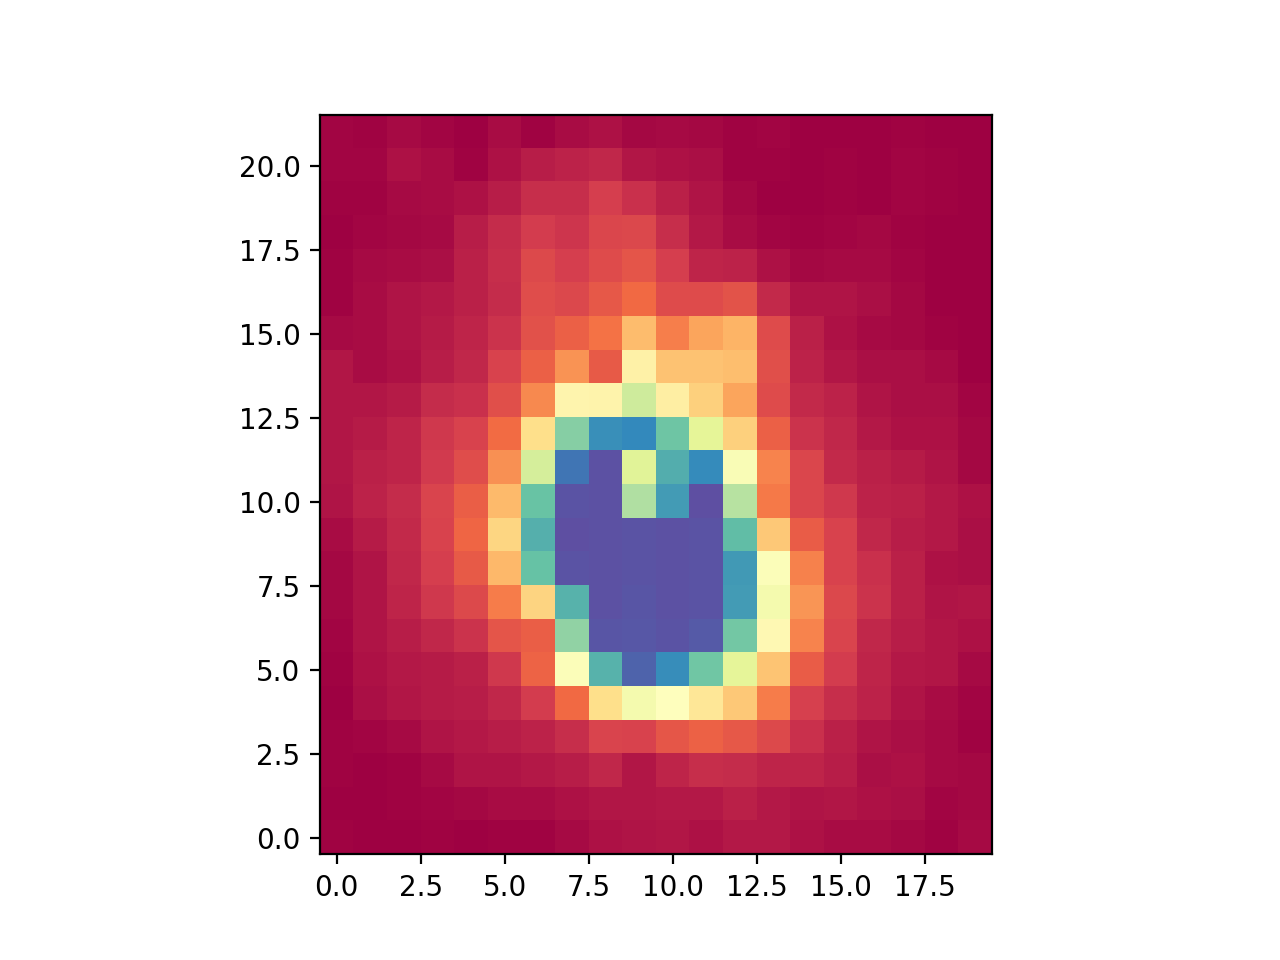

<IPython.core.display.Javascript object>


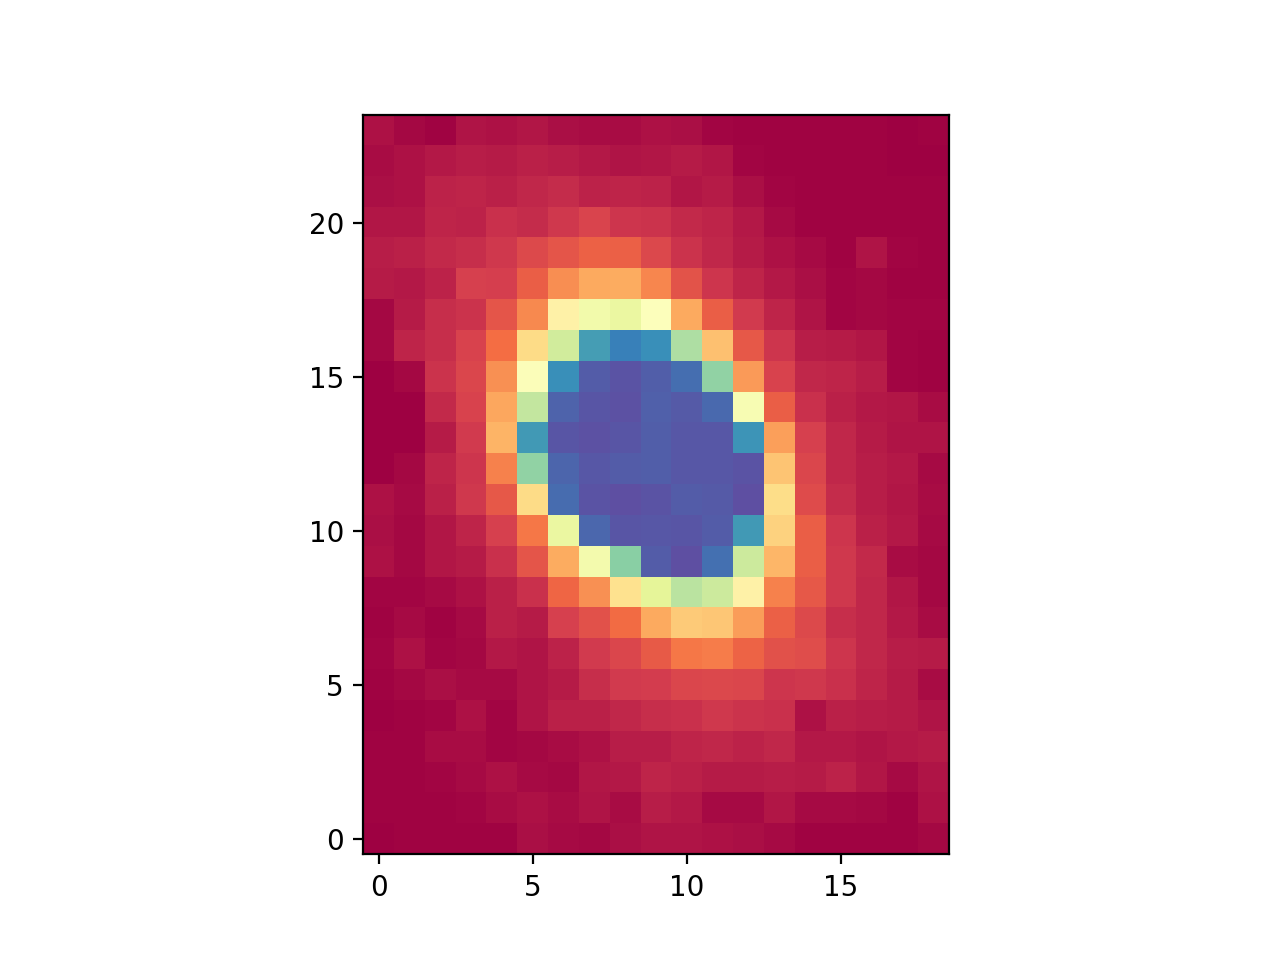

<IPython.core.display.Javascript object>


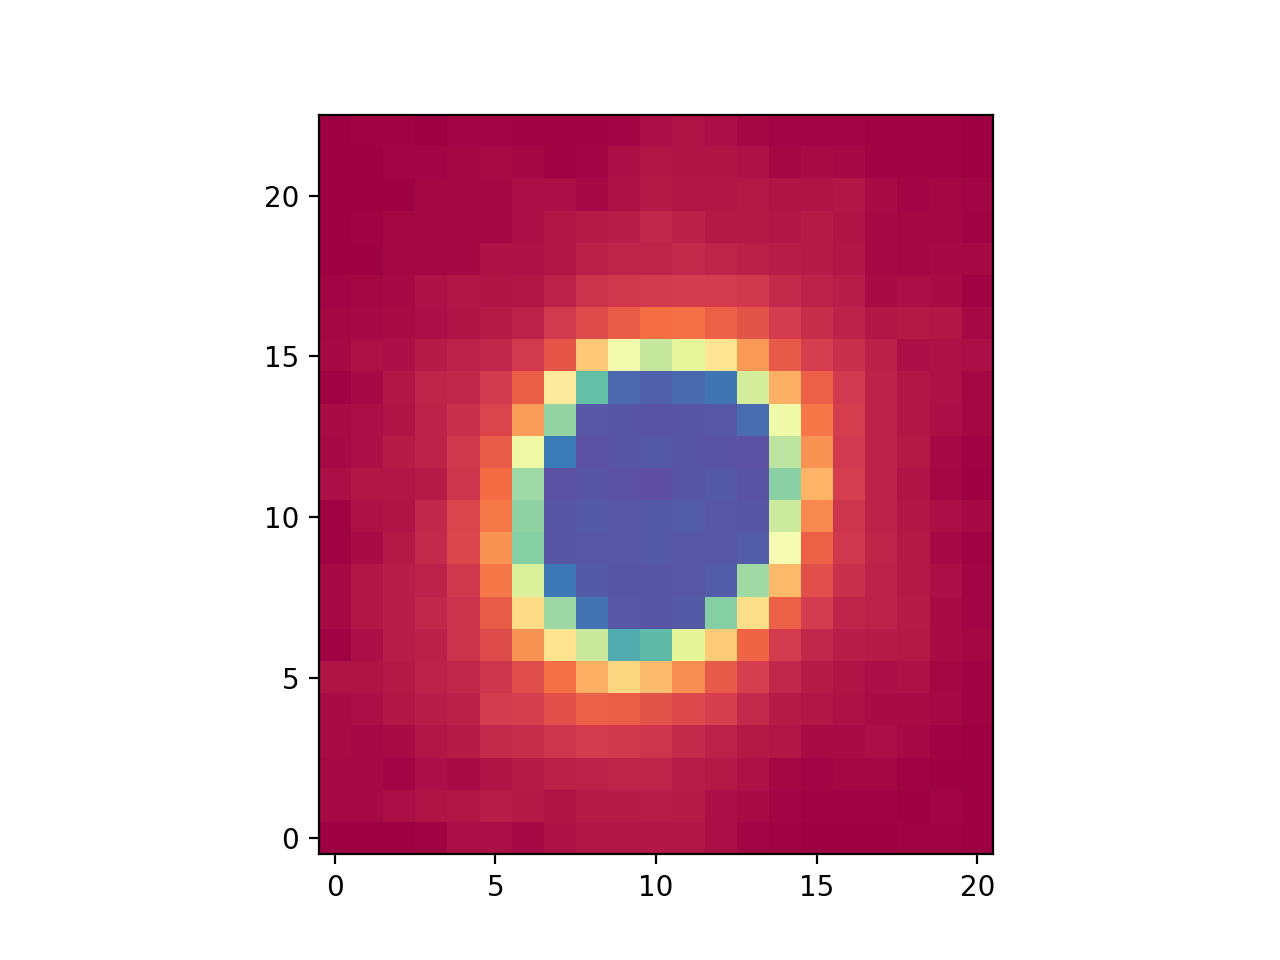

<IPython.core.display.Javascript object>


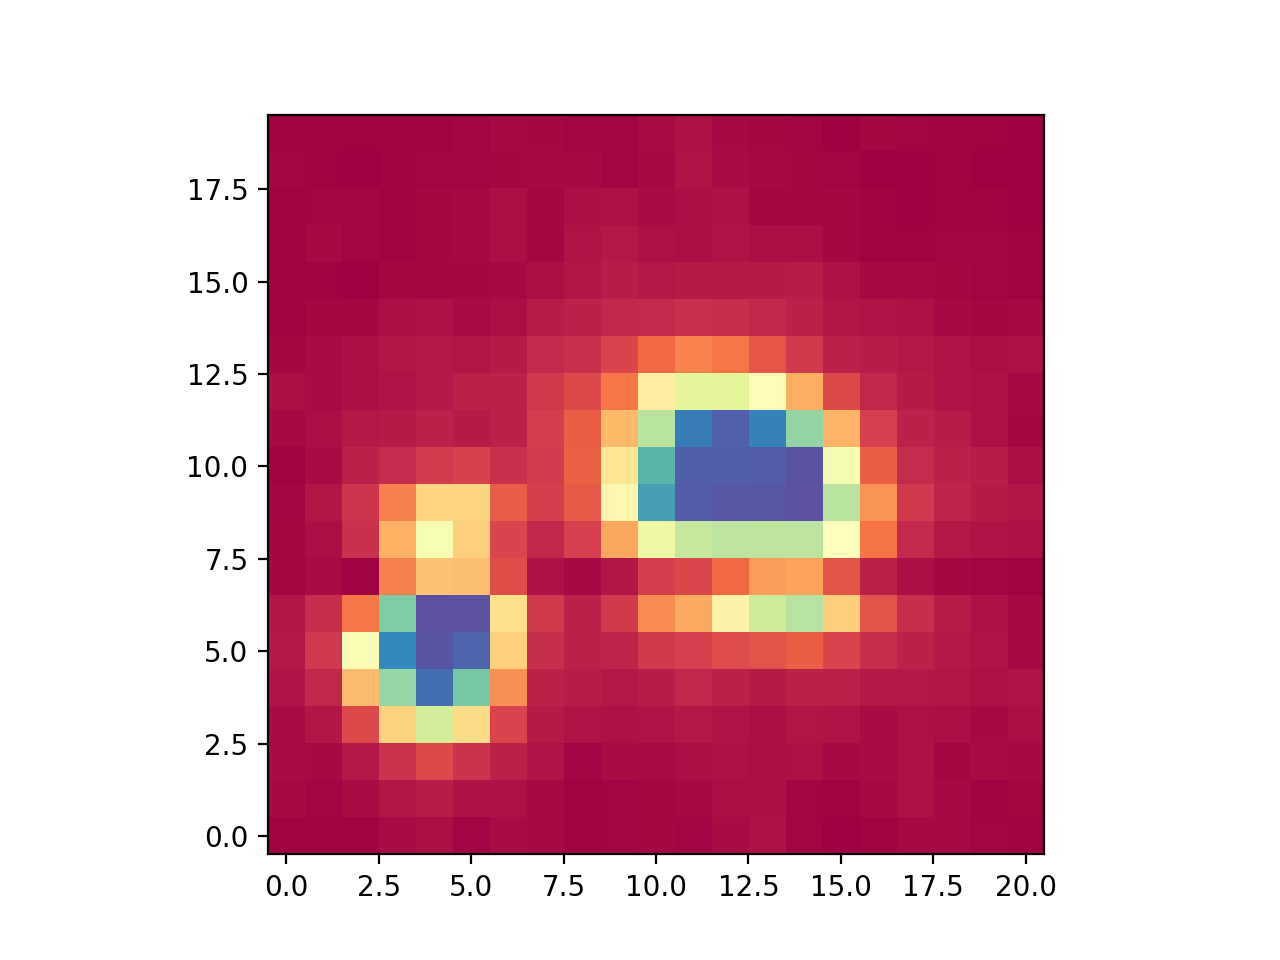

In [9]:
for i in range(len(peak_list)):
    plt.figure()
    img = plt.imshow(peak_list[i], interpolation='nearest', origin='lower', cmap=plt.get_cmap('Spectral'))

In [10]:
index = 0
p = peak_list[index]
qx_index = qx_list[index]
qy_index = qy_list[index]
BG_level = 100 # needs to be optimized
p_sub = p - BG_level
peak_thresh = 2000 # needs to be optimized (roughly 10 photons above background)
p_mask = p_sub > peak_thresh
qx_cm =  np.sum(p[p_mask]*qx_index[p_mask])/np.sum(p[p_mask])
qy_cm =  np.sum(p[p_mask]*qy_index[p_mask])/np.sum(p[p_mask])
#qx_cm =  np.sum(p[p_mask]*qx[peak_regions[index]])/np.sum(p[p_mask])
#qy_cm = np.sum(p[p_mask]*qy[peak_regions[index]])/np.sum(p[p_mask])

<IPython.core.display.Javascript object>


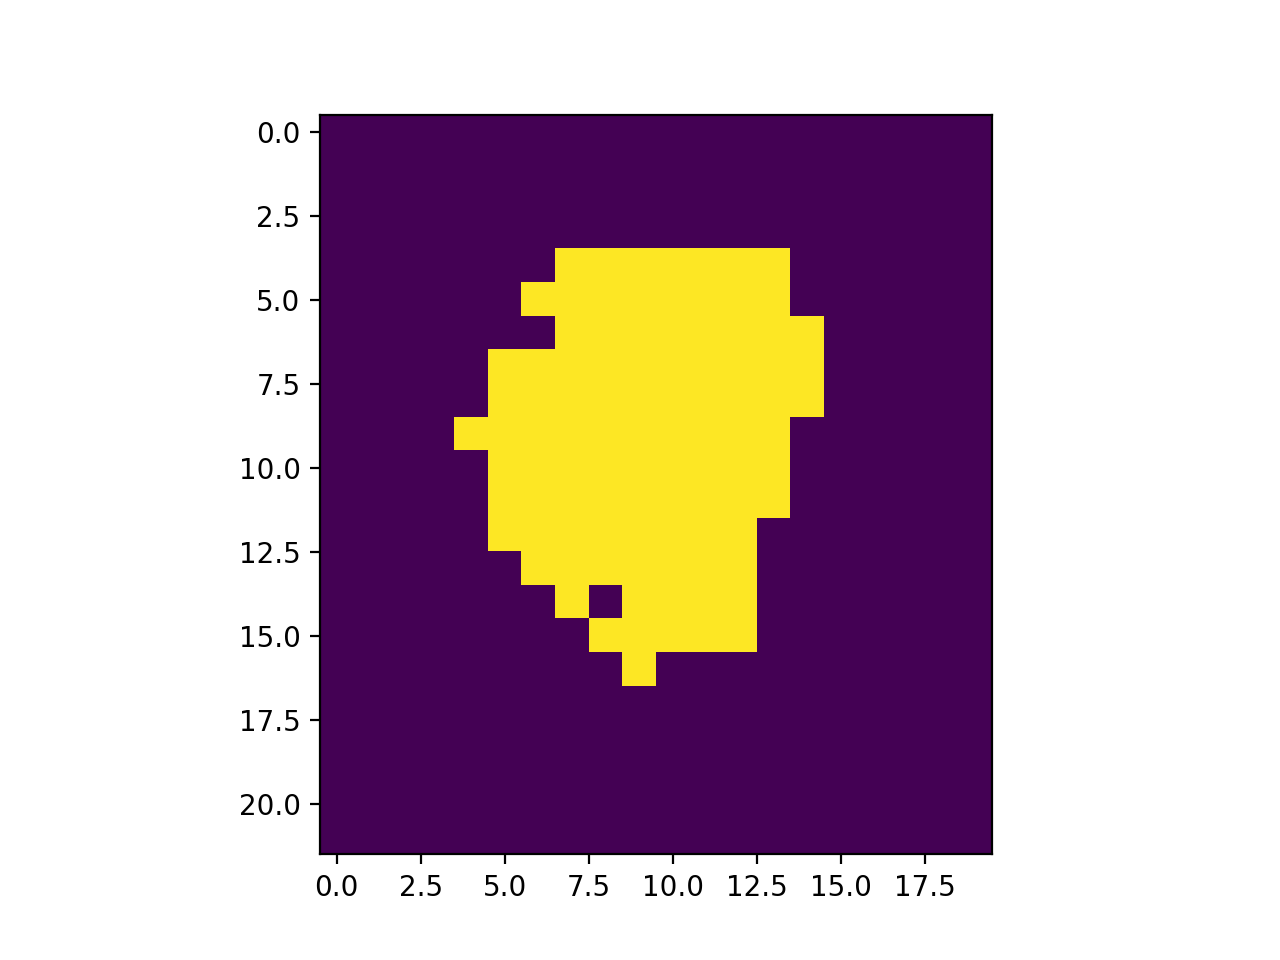

In [11]:
plt.figure()
plt.imshow(p_mask)
p[p_mask]
q_total = np.sqrt(qx_index[p_mask]**2 + qy_index[p_mask]**2)/1e10

In [34]:
from scipy.ndimage.morphology import binary_fill_holes
fill_holes = binary_fill_holes(p_mask)

In [12]:
plt.figure()
plt.imshow(fill_holes)

<IPython.core.display.Javascript object>

NameError: name 'fill_holes' is not defined

In [36]:
fill_holes.astype(np.uint8)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1,

In [13]:
import cv2
# source image, contour retrieval mode, contour approximation method
# output: image, contour and hierarchy
contours, hierarchy = cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print ('Numbers of shapes: {0}'.format(len(contours)))

#cv2.drawContours(im, cv2.UMat(contours),-1,(0,255,0), 3)
#plt.imshow(im)
#plt.show()

#Draw the contours and the objects they enclose??
for cnt in contours:
    #find the moment of the contour
    M = cv2.moments(cnt)
    #finding the center of the contour
    cx1 = int(M['m10']/M['m00'])
    cy1 = int(M['m01']/M['m00'])
    center = (cx1,cy1)
    # get the area of the contour contourArea
    area_drawing = cv2.contourArea(cnt)
    # get the perimeter of the contour 
    perimeter_drawing = cv2.arcLength(cnt, True) 
    # A -> Area P -> Perimeter
    #cv2.putText(fill_holes, 'A: {0:2.1f}'.format(area_drawing), center, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.3, (255,0,0),3)
    #cv2.putText(fill_holes, 'P: {0:2.1f}'.format(perimeter_drawing), (cx1, cy1 + 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.3, (255,0,0),3)
#plt.figure('contour')
#cv2.drawContours(im, contour,-1,(0,255,0), 3)
#plt.imshow(im)
#plt.show()

NameError: name 'fill_holes' is not defined

In [65]:
4*np.pi*area_drawing/(perimeter_drawing**2)

0.6865745854564168

In [14]:
def draw_contour(image, c, i):
    # compute the center of the contour area and draw a circle
    # representing the center
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    # draw the countour number on the image
    cv2.putText(image, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), 2)
    # return the image with the contour number drawn on it
    return image

In [15]:
def find_biggest_contour(image):
    # Copy
    image = image.copy()
    #input, gives all the contours, contour approximation compresses horizontal,
    #vertical, and diagonal segments and leaves only their end points. For example,
    #an up-right rectangular contour is encoded with 4 points.
    #Optional output vector, containing information about the image topology.
    #It has as many elements as the number of contours.
    #we dont need it
    _, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask 

In [16]:
perimeter = cv2.arcLength(contours, True)

NameError: name 'contours' is not defined

In [45]:
img = peak_list[0]

In [17]:
# Contoured image
contours = cv2.findContours(fill_holes,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
for contour in contours:
    cv2.drawContours(im, contour, -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(im)

NameError: name 'fill_holes' is not defined

In [43]:
contour

[array([[[ 7,  4]],
 
        [[ 6,  5]],
 
        [[ 7,  6]],
 
        [[ 6,  7]],
 
        [[ 5,  7]],
 
        [[ 5,  8]],
 
        [[ 4,  9]],
 
        [[ 5, 10]],
 
        [[ 5, 11]],
 
        [[ 5, 12]],
 
        [[ 6, 13]],
 
        [[ 7, 14]],
 
        [[ 8, 15]],
 
        [[ 9, 16]],
 
        [[10, 15]],
 
        [[11, 15]],
 
        [[12, 15]],
 
        [[12, 14]],
 
        [[12, 13]],
 
        [[12, 12]],
 
        [[13, 11]],
 
        [[13, 10]],
 
        [[13,  9]],
 
        [[14,  8]],
 
        [[14,  7]],
 
        [[14,  6]],
 
        [[13,  5]],
 
        [[13,  4]],
 
        [[12,  4]],
 
        [[11,  4]],
 
        [[10,  4]],
 
        [[ 9,  4]],
 
        [[ 8,  4]]], dtype=int32)]

In [132]:
# contour is a list of N coordinate points (x_i, y_i), and the perimeter is computed as
# perimeter = sum(sqrt((x_{i+1} - x_i)^2 + (y_{i+1} - y_i)^2 ))
for pixel_contour in contours:
    #delta_squared = np.diff(pixel_contour, axis=0)*np.diff(pixel_contour, axis=0)
    #perimeter = np.sum(np.sqrt(np.sum(delta_squared, axis=1))) 
    perimeter = cv2.arcLength(contours, True)
    area = cv2.contourArea(pixel_contour)
    sphericity = 4*np.pi*area/(perimeter**2)

TypeError: Expected cv::UMat for argument 'curve'

In [172]:
contour2

[array([[[ 0,  0]],
 
        [[ 0,  1]],
 
        [[ 0,  2]],
 
        [[ 0,  3]],
 
        [[ 0,  4]],
 
        [[ 0,  5]],
 
        [[ 0,  6]],
 
        [[ 0,  7]],
 
        [[ 0,  8]],
 
        [[ 0,  9]],
 
        [[ 0, 10]],
 
        [[ 0, 11]],
 
        [[ 0, 12]],
 
        [[ 0, 13]],
 
        [[ 0, 14]],
 
        [[ 0, 15]],
 
        [[ 0, 16]],
 
        [[ 0, 17]],
 
        [[ 0, 18]],
 
        [[ 0, 19]],
 
        [[ 0, 20]],
 
        [[ 0, 21]],
 
        [[ 0, 22]],
 
        [[ 0, 23]],
 
        [[ 0, 24]],
 
        [[ 0, 25]],
 
        [[ 0, 26]],
 
        [[ 0, 27]],
 
        [[ 0, 28]],
 
        [[ 0, 29]],
 
        [[ 0, 30]],
 
        [[ 0, 31]],
 
        [[ 0, 32]],
 
        [[ 0, 33]],
 
        [[ 0, 34]],
 
        [[ 0, 35]],
 
        [[ 0, 36]],
 
        [[ 0, 37]],
 
        [[ 0, 38]],
 
        [[ 0, 39]],
 
        [[ 0, 40]],
 
        [[ 0, 41]],
 
        [[ 0, 42]],
 
        [[ 0, 43]],
 
        [[ 0, 44]],
 
        [[

In [18]:
binary_fill_holes(q_total).astype(np.uint8)
contour2, hierarchy2 = cv2.findContours(q_total.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for pixel_contour2 in contour2:
    delta_squared2 = np.diff(pixel_contour2, axis=0)*np.diff(pixel_contour2, axis=0)
    perimeter2 = np.sum(np.sqrt(np.sum(delta_squared2, axis=1))) 
    #perimeter = cv2.arcLength(contour, True)
    area2 = cv2.contourArea(pixel_contour2)
    sphericity2 = 4*np.pi*area2/(perimeter2**2)

NameError: name 'binary_fill_holes' is not defined

In [171]:
sphericity2

0.0

In [48]:
q_total

array([1.77049984, 1.77025657, 1.77002123, 1.76979383, 1.76957437,
       1.76936285, 1.76915928, 1.76755609, 1.76730444, 1.76706073,
       1.76682497, 1.76659715, 1.76637729, 1.76616539, 1.76596145,
       1.76410714, 1.76386299, 1.7636268 , 1.76339857, 1.76317831,
       1.76296603, 1.76276172, 1.76256539, 1.76142104, 1.76116051,
       1.76090795, 1.76066335, 1.76042673, 1.76019809, 1.75997743,
       1.75976476, 1.75956008, 1.75936339, 1.75822089, 1.75795989,
       1.75770686, 1.75746182, 1.75722477, 1.75699571, 1.75677465,
       1.75656159, 1.75635653, 1.75615949, 1.75528831, 1.75501885,
       1.75475737, 1.75450388, 1.7542584 , 1.75402091, 1.75379143,
       1.75356997, 1.75335652, 1.75315109, 1.75181492, 1.75155296,
       1.75129901, 1.75105308, 1.75081516, 1.75058526, 1.75036339,
       1.75014955, 1.74994374, 1.74860911, 1.74834667, 1.74809226,
       1.74784587, 1.74760751, 1.74737719, 1.74715491, 1.74694068,
       1.7467345 , 1.74540142, 1.7451385 , 1.74488361, 1.74463

In [83]:
qx_index[contours[0]], qy_index[contours[0]]

(array([[[[-1.42808076e+09, -1.39052412e+09, -1.35296553e+09, ...,
           -7.89388074e+08, -7.51805393e+08, -7.14221654e+08],
          [-1.42808076e+09, -1.39052412e+09, -1.35296553e+09, ...,
           -7.89388074e+08, -7.51805393e+08, -7.14221654e+08]]],
 
 
        [[[-1.42808076e+09, -1.39052412e+09, -1.35296553e+09, ...,
           -7.89388074e+08, -7.51805393e+08, -7.14221654e+08],
          [-1.42808076e+09, -1.39052412e+09, -1.35296553e+09, ...,
           -7.89388074e+08, -7.51805393e+08, -7.14221654e+08]]],
 
 
        [[[-1.42808076e+09, -1.39052412e+09, -1.35296553e+09, ...,
           -7.89388074e+08, -7.51805393e+08, -7.14221654e+08],
          [-1.42808076e+09, -1.39052412e+09, -1.35296553e+09, ...,
           -7.89388074e+08, -7.51805393e+08, -7.14221654e+08]]],
 
 
        ...,
 
 
        [[[-1.42808076e+09, -1.39052412e+09, -1.35296553e+09, ...,
           -7.89388074e+08, -7.51805393e+08, -7.14221654e+08],
          [-1.42808076e+09, -1.39052412e+09, -1.3529655

In [ ]:
def Sphericity(peak_list, BG_level = 100, peak_thresh = 2000):
    for index in range(len(peak_list)):
        p = peak_list[index]
        qx_index = qx_list[index]
        qy_index = qy_list[index]
    p_sub = p - BG_level
    p_mask = p_sub > peak_thresh
    q_total = np.sqrt(qx_index[p_mask]**2 + qy_index[p_mask]**2)/1e10
    fill_holes = binary_fill_holes(p_mask)
    contours, hierarchy = cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [117]:
a = [1.4, 3, 6, 8, 2, 7]
b = np.diff(a, axis=0)
a[-1]

7

In [118]:
np.append(a, a[0]-a[-1])

array([ 1.4,  3. ,  6. ,  8. ,  2. ,  7. , -5.6])

In [89]:
np.diff(contours[0], axis=0)

array([[[-1,  1]],

       [[ 1,  1]],

       [[-1,  1]],

       [[-1,  0]],

       [[ 0,  1]],

       [[-1,  1]],

       [[ 1,  1]],

       [[ 0,  1]],

       [[ 0,  1]],

       [[ 1,  1]],

       [[ 1,  1]],

       [[ 1,  1]],

       [[ 1,  1]],

       [[ 1, -1]],

       [[ 1,  0]],

       [[ 1,  0]],

       [[ 0, -1]],

       [[ 0, -1]],

       [[ 0, -1]],

       [[ 1, -1]],

       [[ 0, -1]],

       [[ 0, -1]],

       [[ 1, -1]],

       [[ 0, -1]],

       [[ 0, -1]],

       [[-1, -1]],

       [[ 0, -1]],

       [[-1,  0]],

       [[-1,  0]],

       [[-1,  0]],

       [[-1,  0]],

       [[-1,  0]]], dtype=int32)

In [202]:
for i in range(len(contours[0])):
    cnt_diff = contours[0][i] - contours[0][i-1]
    delta_squared = cnt_diff*cnt_diff
    perimeter = np.sum(np.sqrt(np.sum(delta_squared, axis=1)))
    area = cv2.contourArea(pixel_contour)
    sphericity = 4*np.pi*area/(perimeter**2)

In [203]:
perimeter

1.0

In [204]:
sphericity

1011.5928344559134

In [199]:
contour, hierarchy = cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for pixel_contour in contour:
    delta_squared = np.diff(pixel_contour, axis=0)*np.diff(pixel_contour, axis=0)
    perimeter = np.sum(np.sqrt(np.sum(delta_squared, axis=1))) 
    #perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(pixel_contour)
    sphericity = 4*np.pi*area/(perimeter**2)
    print(np.diff(pixel_contour, axis=0).shape)

(32, 1, 2)


In [174]:
sphericity

0.49955201701526586

In [175]:
perimeter

45.0

In [165]:
for i in contours:
    perimeter = cv2.arcLength(i, True)
    area = cv2.contourArea(i)
    sphericity = 4*np.pi*area/(perimeter**2)

In [167]:
perimeter

38.38477599620819

In [137]:
sphericity

0.6865745854564168